In [9]:
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator

# input data
plt.style.use("../data/inputs/ploting.mplstyle")
results_dir = Path("../data/results/MULTI-STATIONS -- 20251222_002304 -- f4c9/THUNDER BAY A-6048261")

# Load Data

In [10]:
df_ranks = pd.read_csv(results_dir / "02_copula_fitting/01_input_ranks.csv")
metrics = pd.read_csv(results_dir / "02_copula_fitting/02_copula_fit_metrics.csv")
cdf = pd.read_csv(results_dir / "02_copula_fitting/03_cdf_results.csv")
return_periods = pd.read_csv(results_dir / "02_copula_fitting/04_return_periods.csv")

# Reorder columns to have 'Analytical' as the second column
if 'Analytical' in cdf.columns:
    first_col = cdf.columns[0]
    other_cols = [c for c in cdf.columns if c not in [first_col, 'Analytical']]
    cdf = cdf[[first_col, 'Analytical'] + other_cols]
if 'Analytical' in return_periods.columns:
    first_col = return_periods.columns[0]
    other_cols = [c for c in return_periods.columns if c not in [first_col, 'Analytical']]
    return_periods = return_periods[[first_col, 'Analytical'] + other_cols]


print("Data loaded successfully.")
display(return_periods)

Data loaded successfully.


,ReturnPeriod,Analytical,Gaussian,t,Clayton,Frank,Gumbel
0,2.0,26.972053,25.336195,25.381791,26.046664,25.714270,25.239900
1,5.0,32.875282,31.171162,31.230414,31.945254,31.598687,31.131249
2,10.0,37.319533,35.620839,35.685726,36.394527,36.055027,35.596894
3,25.0,43.227736,41.498608,41.574366,42.291167,41.956104,41.486265
4,50.0,47.697258,45.966257,46.046452,46.767240,46.400157,45.946704
5,100.0,52.159866,50.417864,50.519066,51.224933,50.881356,50.398702


# 1. Input Data Ranks (Dependency Structure)

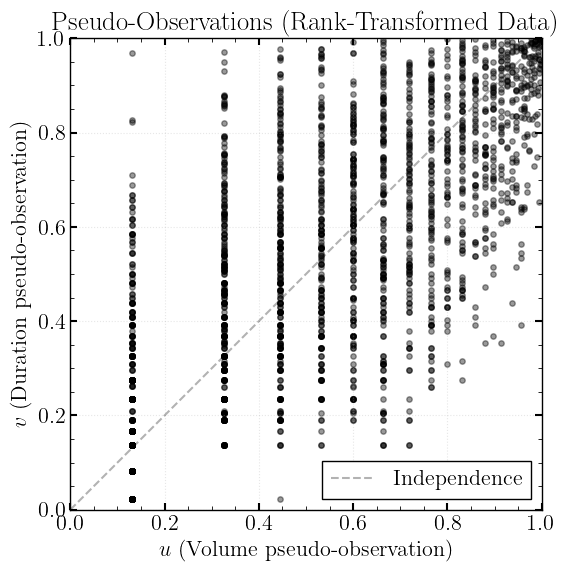

In [11]:
"""
Scatter plot of pseudo-observations (ranks) in unit square.
"""
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(df_ranks['u_duration'], df_ranks["v_volume"], alpha=0.4, s=15)

ax.set_xlabel(r'$u$ (Volume pseudo-observation)')
ax.set_ylabel(r'$v$ (Duration pseudo-observation)')
ax.set_title('Pseudo-Observations (Rank-Transformed Data)')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect('equal')
ax.grid(True, linestyle=':', alpha=0.3)

# Add diagonal reference line (independence)
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Independence')
ax.legend()

plt.tight_layout()
# plt.savefig(save_path, dpi=300, bbox_inches='tight')

# 2. Copula Fit Metrics Comparison

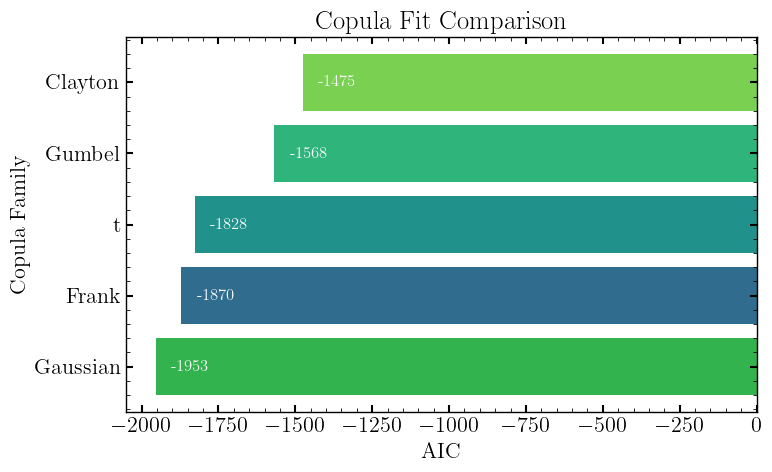

In [12]:
"""
Horizontal bar chart comparing copula fits by AIC.

Parameters:
    metrics_df: DataFrame with 'Family' and 'AIC' columns
    save_path: Optional path to save figure
"""
fig, ax = plt.subplots(figsize=(8, 5))

# Sort by AIC (lower is better)
sorted_df = metrics.sort_values('AIC', ascending=True)

# Color gradient
n = len(sorted_df)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, n))
colors[0] = [0.2, 0.7, 0.3, 1]  # Green for best

bars = ax.barh(sorted_df['Family'], sorted_df['AIC'], color=colors)

# AIC (lower is better)
ax.set_xlabel('AIC')
ax.set_ylabel('Copula Family')
ax.set_title('Copula Fit Comparison')

# Add value labels
for bar, aic in zip(bars, sorted_df['AIC']):
    ax.text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2, 
            f'{aic:.0f}', va='center', fontsize=12, fontweight='bold', color='white')


plt.tight_layout()
# plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

# 3. CDF Comparison

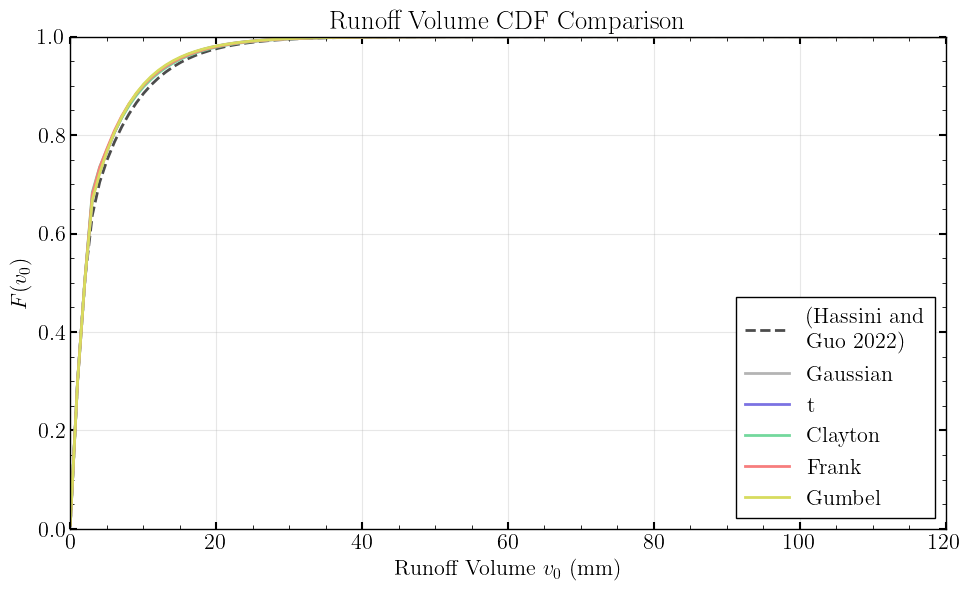

In [13]:
"""
Plot CDF curves for all copulas + analytical solution.
"""
fig, ax = plt.subplots(figsize=(10, 6))

# Plot analytical (dashed)
if 'Analytical' in cdf.columns:
    ax.plot(cdf['v0'], cdf['Analytical'], '--', linewidth=2, 
            label='(Hassini and\n Guo 2022)', alpha=0.7)

# Plot copula CDFs
copula_cols = [c for c in cdf.columns if c not in ['v0', 'Analytical']]
for copula in copula_cols:
    ax.plot(cdf['v0'], cdf[copula], linewidth=2, label=copula)

ax.set_xlabel(r'Runoff Volume $v_0$ (mm)')
ax.set_ylabel(r'$F(v_0)$')
ax.legend(loc='lower right')
ax.set_xlim(0, cdf['v0'].max())
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)

plt.tight_layout()
ax.set_title('Runoff Volume CDF Comparison')
# plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

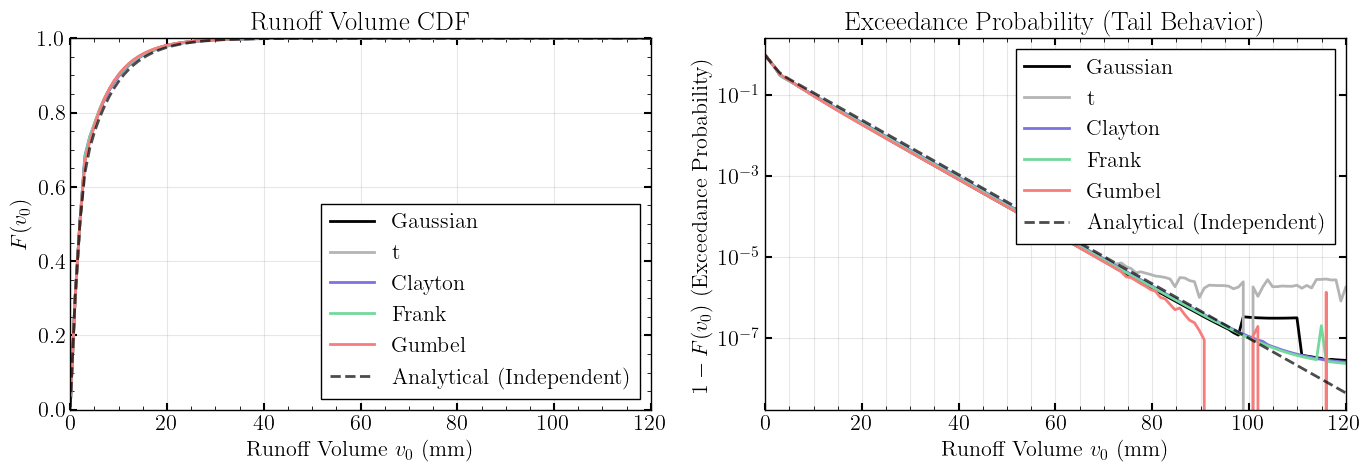

In [14]:
"""
Combined plot showing CDF curves with zoomed inset for tail behavior.
Provides a comprehensive view of copula fitting results.
"""

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Auto-detect copula columns
if copula_cols is None:
    copula_cols = [c for c in cdf.columns if c not in ['v0', 'Analytical']]

# --- Left plot: Full CDF ---
ax1 = axes[0]
for copula in copula_cols:
    ax1.plot(cdf['v0'], cdf[copula], linewidth=2, label=copula)

if 'Analytical' in cdf.columns:
    ax1.plot(cdf['v0'], cdf['Analytical'], 'k--', linewidth=2, 
            label='Analytical (Independent)', alpha=0.7)

ax1.set_xlabel(r'Runoff Volume $v_0$ (mm)')
ax1.set_ylabel(r'$F(v_0)$')
ax1.set_title('Runoff Volume CDF')
ax1.legend(loc='lower right')
ax1.set_xlim(0, cdf['v0'].max())
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)

# --- Right plot: Zoomed tail region (exceedance probability) ---
ax2 = axes[1]
for copula in copula_cols:
    ax2.plot(cdf['v0'], 1 - cdf[copula], linewidth=2, label=copula)

if 'Analytical' in cdf.columns:
    ax2.plot(cdf['v0'], 1 - cdf['Analytical'], 'k--', linewidth=2, 
            label='Analytical (Independent)', alpha=0.7)

ax2.set_xlabel(r'Runoff Volume $v_0$ (mm)')
ax2.set_ylabel(r'$1 - F(v_0)$ (Exceedance Probability)')
ax2.set_title('Exceedance Probability (Tail Behavior)')
ax2.legend(loc='upper right')
ax2.set_yscale('log')
ax2.set_xlim(0, cdf['v0'].max())
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
# plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

# 4. Return Periods Analysis

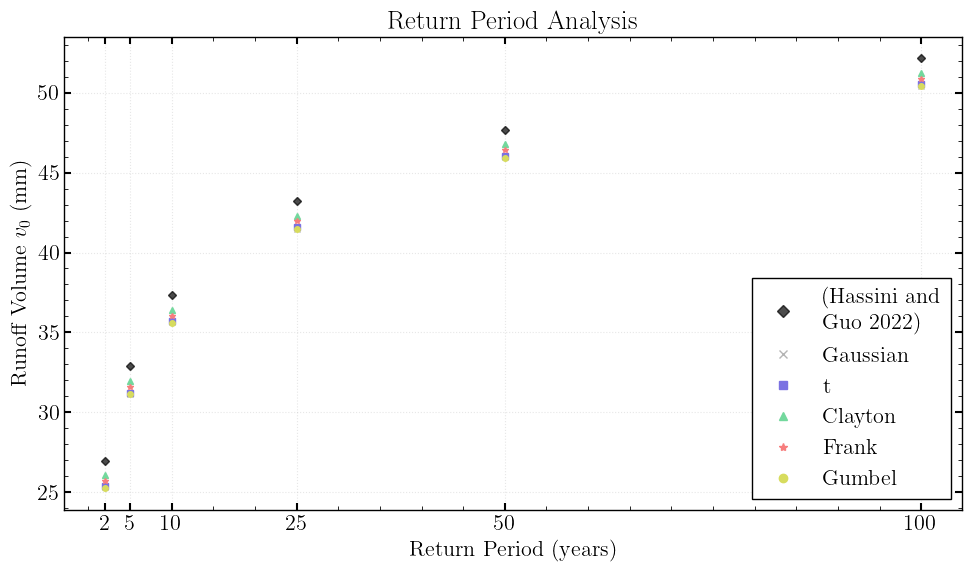

In [15]:
"""
Plot return period curves (log-scale x-axis).
"""
fig, ax = plt.subplots(figsize=(10, 6))

markers=['D', 'x', 's', '^', '*', 'o']

# Plot Analytical Return Period
if 'Analytical' in return_periods.columns:
    ax.plot(return_periods['ReturnPeriod'], return_periods['Analytical'], markers[0],
            linewidth=2, markersize=4, label='(Hassini and\n Guo 2022)', alpha=0.7)

# Plot copula Return Periods
copula_cols = [r for r in return_periods.columns if r not in ['ReturnPeriod', 'Analytical']]
for i, copula in enumerate(copula_cols):
    ax.plot(return_periods['ReturnPeriod'], return_periods[copula], markers[i+1],
            linewidth=2, markersize=4, label=copula)


# for i, copula in enumerate(copula_cols):
#     ax.plot(return_periods["ReturnPeriod"], return_periods[copula], marker[i], 
#             linewidth=2, markersize=4, label=copula)

ax.set_xlabel('Return Period (years)')
ax.set_ylabel(r'Runoff Volume $v_0$ (mm)')
ax.set_title('Return Period Analysis')
ax.legend(markerscale=1.5)
ax.grid(True, linestyle=':', alpha=0.3)

# Format x-axis
ax.set_xticks(return_periods["ReturnPeriod"])
ax.xaxis.set_minor_locator(MultipleLocator(5)) 

plt.tight_layout()
# plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

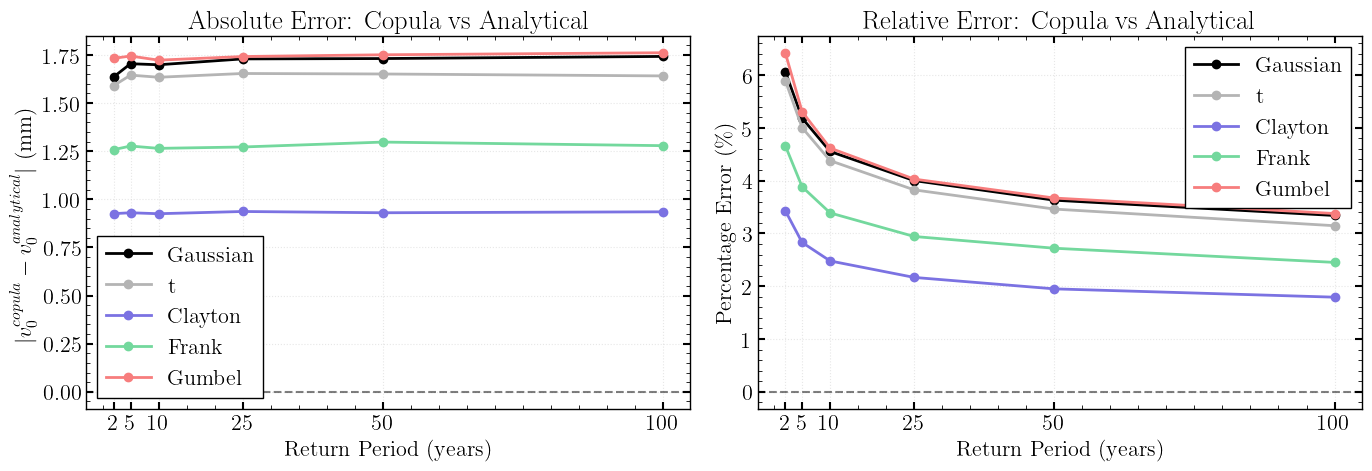

In [16]:
"""
Plot error between copula return periods and analytical model.
Shows percentage difference for each copula family.
"""
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

copula_cols = [c for c in return_periods.columns 
                if c not in ["ReturnPeriod", "Analytical"]]

# --- Left plot: Absolute error ---
ax1 = axes[0]
for copula in copula_cols:
    error = abs(return_periods[copula] - return_periods["Analytical"])
    ax1.plot(return_periods["ReturnPeriod"], error, 'o-', 
            linewidth=2, markersize=6, label=copula)

ax1.axhline(0, color='black', linestyle='--', alpha=0.5)
ax1.set_xlabel('Return Period (years)')
ax1.set_ylabel(r'$|v_0^{copula} - v_0^{analytical}|$ (mm)')
ax1.set_title('Absolute Error: Copula vs Analytical')
ax1.legend(loc='best')
ax1.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax1.xaxis.set_minor_locator(MultipleLocator(5)) 
ax1.set_xticks(return_periods['ReturnPeriod'])
ax1.grid(True, linestyle=':', alpha=0.3)

# --- Right plot: Percentage error ---
ax2 = axes[1]
for copula in copula_cols:
    pct_error = abs((return_periods[copula] - return_periods["Analytical"]) 
                    / return_periods["Analytical"] * 100)
    ax2.plot(return_periods["ReturnPeriod"], pct_error, 'o-', 
            linewidth=2, markersize=6, label=copula)

ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
ax2.set_xlabel('Return Period (years)')
ax2.set_ylabel(r'Percentage Error (\%)')
ax2.set_title('Relative Error: Copula vs Analytical')
ax2.legend(loc='best')
ax2.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax2.xaxis.set_minor_locator(MultipleLocator(5)) 
ax2.set_xticks(return_periods['ReturnPeriod'])
ax2.grid(True, linestyle=':', alpha=0.3)

plt.tight_layout()
# plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()